# ISFEST 2022 - TEAM ODE (OH DATA EUY)
Anggota Team
- Felix Fernando
- Gerend Christopher
- Jeremy 



Permasalahan masalah penelitian mengacu pada performansi studi mahasiswa suatu perguruan tinggi berdasarkan waktu studi. Tujuan dari penelitian ini adalah menentukan model klasifikasi yang tepat untuk dapat melakukan prediksi kelulusan yang baik dari beberapa model. Penerapan data mining pada penelitian ini berhubungan langsung dengan data nilai mahasiswa untuk menggali pengetahuan tentang suatu pola kelulusan mahasiswa yang tepat waktu, serta untuk menentukan model klasifikasi yang memberikan nilai akurasi yang baik berdasarkan pola kelulusan yang ada berkaitan dengan parameter-parameter nilai input.


## Setup

In [182]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
from scipy.stats import skew, kurtosis
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [462]:
# Membuat dataframe data csv
df1 = pd.read_csv("Dataset1_TranscriptMahasiswa.csv", sep=";", dtype={"NIM" :"object", "NAMA_MK" : "string"})
df2 = pd.read_csv("Dataset2_EvaluasiDosenPerMK.csv", sep=";", decimal=",")

In [184]:
# Banyak Mahasiswa
print('Ada', df1["NIM"].nunique(), 'Mahasiswa')

Ada 770 Mahasiswa


In [185]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30870 entries, 0 to 30869
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   NIM       30870 non-null  object 
 1   ANGKATAN  30870 non-null  int64  
 2   SEMESTER  30870 non-null  int64  
 3   KODE_MK   30870 non-null  object 
 4   NAMA_MK   30847 non-null  string 
 5   SKS       30870 non-null  int64  
 6   NILAI     30858 non-null  float64
 7   GRADE     30318 non-null  object 
dtypes: float64(1), int64(3), object(3), string(1)
memory usage: 1.9+ MB


Terdapat data null untuk df1

In [186]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2114 entries, 0 to 2113
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TAHUN       2114 non-null   int64  
 1   SEMESTER    2114 non-null   int64  
 2   MATAKULIAH  2114 non-null   object 
 3   PERTANYAAN  2114 non-null   int64  
 4   KETERANGAN  2114 non-null   object 
 5   NILAI       2114 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 99.2+ KB


Tidak terdapat data null untuk df2

## Data Cleansing dan Data Preparation

### Dataframe 1 (Data Nilai Mahasiswa)

In [187]:
# check null tiap kolom df1
df1.isnull().any()

NIM         False
ANGKATAN    False
SEMESTER    False
KODE_MK     False
NAMA_MK      True
SKS         False
NILAI        True
GRADE        True
dtype: bool

In [463]:
# check Kode_MK dari Nama_MK yang null
df1['KODE_MK'][df1['NAMA_MK'].isnull()].unique()

array(['SI863'], dtype=object)

In [464]:
df1["SEMESTER"].unique()

array([1011, 1021, 1111, 1121, 1211, 1221, 1311, 1321, 1322, 1122, 1222,
       1411, 1421, 1022, 1422, 1511, 1621, 1521, 1611, 1711, 1721, 1722,
       1522, 1821, 1811, 1622, 1822, 1911], dtype=int64)

In [465]:
# fill Nama_MK yang null
df1["NAMA_MK"] = df1["NAMA_MK"].fillna("Tugas Akhir") # Kebetulan yang null cuman SI863

# add kode MK ke Nama_MK
for i in df1.index:  
    if df1.at[i, "KODE_MK"] not in df1.at[i, "NAMA_MK"].split(" ") : 
        df1.at[i, "NAMA_MK"] = df1.at[i, "KODE_MK"] + " " + df1.at[i, "NAMA_MK"]

In [466]:
indeks = ["A", "A-", "B+", "B", "B-", "C+", "C", "D", "E", "F"]
bobot = [4, 3.7, 3.3, 3.0, 2.7, 2.3, 2.0, 1.0, 0, 0]
ranges = [[100, 85], [84.99, 80], [79.99, 75], [74.99, 70], [69.99, 65], [64.99, 60], [59.99, 55], [54.99, 45], [44.99,0]]

# fill grade yang null

for i in df1.index:
    for j in ranges:
        if j[1] <= df1.at[i, "NILAI"] <= j[0]:
            df1.at[i, "GRADE"] = indeks[ranges.index(j)]

# menambah total bobot = bobot x sks

for i in df1.index:
    for j in indeks:
        if df1.at[i, "GRADE"] == j:
            df1.at[i, "BOBOT"] = bobot[indeks.index(j)]
            df1.at[i, "TOTAL_BOBOT"] = df1.at[i, "BOBOT"] * df1.at[i, "SKS"]

In [467]:
# re-check null pada kolom GRADE
df1[df1['GRADE'].isnull()]

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT,TOTAL_BOBOT


In [468]:
# check kolom NILAI yang null
df1[df1['NILAI'].isnull()]

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT,TOTAL_BOBOT
18866,00000009931,2015,1811,IS341,IS341 Sistem Basis Data,3,NaN,F,0.0,0.0
21965,00000012407,2015,1621,IS432,IS432 Pengantar E-Business,3,NaN,F,0.0,0.0
22633,00000013019,2016,1821,IS670,IS670 Audit Sistem Informasi,3,NaN,F,0.0,0.0
25920,00000019365,2017,1811,IS341,IS341 Sistem Basis Data,3,NaN,F,0.0,0.0
26030,00000019601,2017,1721,IS201,IS201 Proses Bisnis Korporat,3,NaN,F,0.0,0.0
26760,00000021116,2017,1711,IF110,IF110 Pengantar Teknologi Multimedia,3,NaN,F,0.0,0.0
26901,00000021159,2017,1821,UM321,UM321 Bahasa Inggris 3,2,NaN,F,0.0,0.0
27520,00000022742,2017,1721,IS230,IS230 Algoritma dan Pemrograman,3,NaN,F,0.0,0.0
27774,00000023564,2017,1721,IS230,IS230 Algoritma dan Pemrograman,3,NaN,F,0.0,0.0
29423,00000028446,2018,1821,IS220,IS220 Interaksi Manusia dan Komputer,3,NaN,F,0.0,0.0


Semua NILAI null berasal dari GRADE F \
Oleh karena itu GRADE F berarti nilainya 0, kolom NILAI akan diisi dengan angka 0

In [469]:
# fill null pada kolom NILAI
df1["NILAI"] = df1["NILAI"].fillna(0)
df1[df1['NILAI'].isnull()]

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT,TOTAL_BOBOT


In [470]:
# check nim yang duplicate mk

def checkDuplicate():
    nim_mhs = df1['NIM'].unique()
    nim_for_doubled = []

    for nim in nim_mhs:
        dummy_df1 = df1.loc[df1['NIM'] == nim]
        if dummy_df1['NAMA_MK'].duplicated().any():
            nim_for_doubled.append(nim)
            
    return nim_for_doubled

print(f'Ada {len(checkDuplicate())} mahasiswa yang mengambil suatu mata kuliah secara berulang')

Ada 17 mahasiswa yang mengambil suatu mata kuliah secara berulang


In [196]:
# drop Mata Kuliah yang berulang dan menyimpan mata kuliah terakhir kali diambil

df1 = df1.drop_duplicates(subset=['KODE_MK', 'NIM'], keep='last')

In [197]:
print(f'Setelah drop duplicates, ada {len(checkDuplicate())} mahasiswa yang mengambil suatu mata kuliah secara berulang')

Setelah drop duplicates, ada 0 mahasiswa yang mengambil suatu mata kuliah secara berulang


In [198]:
df1.head()

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT,TOTAL_BOBOT
0,10110310002,2010,1011,EM100,EM100 Dasar-dasar Bisnis,3,57.0,C,2.0,6.0
1,10110310002,2010,1011,EM180,EM180 Matematika Bisnis,3,70.0,B,3.0,9.0
2,10110310002,2010,1011,TI100,TI100 Algoritma dan Pemrograman,4,57.0,C,2.0,8.0
3,10110310002,2010,1011,TI101,TI101 Matematika Diskrit,3,59.0,C,2.0,6.0
4,10110310002,2010,1011,TI110,TI110 Pengantar Teknologi Multimedia,3,74.0,B,3.0,9.0


In [471]:
checkDuplicate()

['10110310011',
 '10110310022',
 '10110310036',
 '10110310037',
 '10110310044',
 '10110310045',
 '10110310047',
 '10110310083',
 '11110310003',
 '11110310004',
 '11110310005',
 '11110310009',
 '11110310020',
 '11110310026',
 '11110310035',
 '11110310080',
 '13110310069']

### Dataframe 2 (Evaluasi Dosen)

In [199]:
# check null tiap kolom df2
df2.isnull().any()

TAHUN         False
SEMESTER      False
MATAKULIAH    False
PERTANYAAN    False
KETERANGAN    False
NILAI         False
dtype: bool

In [200]:
for i in df2.index:  
    df2.at[i,"KODE_MK"] = df2.at[i, "MATAKULIAH"].split(" ")[0]  
df2.head(14)

,TAHUN,SEMESTER,MATAKULIAH,PERTANYAAN,KETERANGAN,NILAI,KODE_MK
0,2015,1511,IS100 Management Information Systems,1,Kesiapan memberikan perkuliahan/praktikum,3.28,IS100
1,2015,1511,IS100 Management Information Systems,2,Upaya menyampaikan materi perkuliahan/praktik...,3.25,IS100
2,2015,1511,IS100 Management Information Systems,3,Sistematis dalam menyampaikan materi perkuliah...,3.24,IS100
3,2015,1511,IS100 Management Information Systems,4,Kemampuan memberikan contoh yang relevan dari ...,3.30,IS100
4,2015,1511,IS100 Management Information Systems,5,Penyampaian materi perkuliahan sesuai dengan k...,3.27,IS100
5,2015,1511,IS100 Management Information Systems,6,Pemakaian buku teks sebagai buku utama perkuli...,3.19,IS100
6,2015,1511,IS100 Management Information Systems,7,Memberi review materi perkuliahan sebelumnya,3.18,IS100
7,2015,1511,IS100 Management Information Systems,8,"Pemberian kesempatan bertanya, berdiskusi sert...",3.32,IS100
8,2015,1511,IS100 Management Information Systems,9,Kejelasan menjawab pertanyaan /diskusi di kelas,3.29,IS100
9,2015,1511,IS100 Management Information Systems,10,Pemberian tugas/kuis serta pembahasannya di kelas,3.24,IS100


## Data Preparation

### Dataframe 3 (Data Transkrip Mahasiswa per NIM) - Modifikasi Dataframe 1

In [201]:
# Pembuataan Dataframe dengan grouping data berdasarkan NIM

# Perhitungan SKS
df3_ = pd.DataFrame(df1.groupby(["NIM", "ANGKATAN"])["SKS"].sum().reset_index())

# Perhitungan Grade
df3__ = pd.DataFrame(df1.loc[(df1["GRADE"] == "D") | (df1["GRADE"] == "E") | (df1["GRADE"] == "F")].groupby("NIM")["GRADE"].sum().reset_index())

# Perhitungan Total Bobot
df3___ = pd.DataFrame((df1.groupby("NIM")["TOTAL_BOBOT"].sum().reset_index()))

# Perhitungan jumlah semester
df3____ =  pd.DataFrame((((df1.groupby("NIM")["SEMESTER"].max() - df1.groupby("NIM")["SEMESTER"].min()) / 100).reset_index()))

df3_____ = pd.DataFrame(df1.groupby('NIM')["ANGKATAN"])
# Merging Dataframe
df3 = pd.merge(df3_, df3__, how="left", on=["NIM"])
df3 = pd.merge(df3, df3___, how="left", on=["NIM"])
df3 = pd.merge(df3, df3____, how="left", on=["NIM"])
df3["GRADE"] = df3["GRADE"].fillna("")

df3.rename(columns = {"GRADE" : "FAILED_GRADE", "SKS" : "TOTAL_SKS", "SEMESTER" : "WAKTU_KULIAH"}, inplace = True)

# Perhitungan IPK
for i in df3.index:
    df3.at[i ,"IPK"] = df3.at[i, "TOTAL_BOBOT"] / df3.at[i, "TOTAL_SKS"]
    if df3.at[i, "WAKTU_KULIAH"] - int(df3.at[i, "WAKTU_KULIAH"]) != 0: 
        df3.at[i, "WAKTU_KULIAH"] = int(df3.at[i, "WAKTU_KULIAH"]) + 0.5
    df3.at[i, "TOTAL_FAILED_GRADE"] = len(df3.at[i, "FAILED_GRADE"])

In [202]:
# Kolom :
# Hasil : TIDAK LULUS, LULUS, TEPAT WAKTU

for i in df3.index:
    if df3.at[i, "TOTAL_SKS"] >= 144 and df3.at[i, "FAILED_GRADE"] == "" and df3.at[i, "IPK"] >= 2.5:
        if df3.at[i, "WAKTU_KULIAH"] <= 4:
            df3.at[i, "HASIL"] = "Lulus Tepat Waktu"
        else: 
            df3.at[i, "HASIL"] = "Lulus Telat"
        # df3.at[i, "HASIL"] = "Lulus"
    else:  
        df3.at[i, "HASIL"] = "Tidak Lulus"

In [203]:
df3.head()

,NIM,ANGKATAN,TOTAL_SKS,FAILED_GRADE,TOTAL_BOBOT,WAKTU_KULIAH,IPK,TOTAL_FAILED_GRADE,HASIL
0,00000008429,2015,145,D,474.5,3.5,3.272414,1.0,Tidak Lulus
1,00000008455,2015,136,DD,416.2,3.5,3.060294,2.0,Tidak Lulus
2,00000008481,2015,127,DDDEEED,313.6,3.5,2.469291,7.0,Tidak Lulus
3,00000008631,2015,145,,519.3,3.0,3.581379,0.0,Lulus Tepat Waktu
4,00000008684,2015,145,,512.1,3.0,3.531724,0.0,Lulus Tepat Waktu


### Dataframe 4 (Data Evaluasi Dosen per Semester dan Mata Kuliah) - Modifikasi Dataframe 1 dan Dataframe 2

In [204]:
# nilai rata-rata dari tiap matakuliah

df4 = pd.DataFrame(df2.groupby(["TAHUN", "MATAKULIAH", "SEMESTER", "KODE_MK"])["NILAI"].mean().reset_index())
df4.rename(columns = {"MATAKULIAH" : "NAMA_MK","NILAI" : "NILAI_RATA-RATA"}, inplace = True)

In [205]:
# Banyaknya mahasiswa yang lulus pada masing-masing mata kuliah tiap semesternya
df1_ = pd.DataFrame(df1.groupby(["KODE_MK", "SEMESTER", "GRADE"]).size().reset_index())
df1_.rename(columns = {0 : "TOTAL"}, inplace = True)
df1_.head() 

,KODE_MK,SEMESTER,GRADE,TOTAL
0,CE441,1421,A,2
1,CE441,1421,A-,7
2,CE441,1421,B,10
3,CE441,1421,B+,3
4,CE441,1421,B-,7


In [206]:
# Perhitungan jumlah mahasiswa lulus dan tidak lulus untuk mata kuliah di setiap semester
for i in df4.index: 
    lulus = 0
    tidak_lulus = 0
    for j in df1_.index:
        if df4.at[i, "KODE_MK"] == df1_.at[j, "KODE_MK"] and df4.at[i, "SEMESTER"] == df1_.at[j, "SEMESTER"]:
            if df1_.at[j, "GRADE"] == "D" or df1_.at[j, "GRADE"] == "E" or df1_.at[j, "GRADE"] == "F":
                tidak_lulus += df1_.at[j, "TOTAL"]
            else: 
                lulus += df1_.at[j, "TOTAL"]
    df4.at[i, "LULUS"] = lulus  
    df4.at[i, "TIDAK_LULUS"] = tidak_lulus  
    for k in df2.index:
        if df4.at[i, "KODE_MK"] == df2.at[k, "KODE_MK"] and df4.at[i, "SEMESTER"] == df2.at[k, "SEMESTER"]:
            df4.at[i, df2.at[k, "PERTANYAAN"]] = df2.at[k, "NILAI"] 
    

In [207]:
# Perhitungan proporsi kelulusan pada kelas yang bersangkutan
df4["PROPORSI_LULUS"] = df4["LULUS"] / (df4["LULUS"] + df4["TIDAK_LULUS"])  

In [208]:
# Melakukan pengecekan terhadap data dengan jumlah mahasiswa 0
df4.loc[(df4["LULUS"] == 0) & (df4["TIDAK_LULUS"] == 0)]

,TAHUN,NAMA_MK,SEMESTER,KODE_MK,NILAI_RATA-RATA,LULUS,TIDAK_LULUS,1,2,3,...,6,7,8,9,10,11,12,13,14,PROPORSI_LULUS
37,2015,IS748 Database Application Development 2,1511,IS748,3.521429,0.0,0.0,3.5,3.5,3.56,...,3.44,3.56,3.5,3.5,3.44,3.5,3.56,3.56,3.56,NaN


In [209]:
# Tidak ada yang pernah mengambil mata kuliah dengan kode IS748
df1.loc[df1["KODE_MK"] == "IS748"]

,NIM,ANGKATAN,SEMESTER,KODE_MK,NAMA_MK,SKS,NILAI,GRADE,BOBOT,TOTAL_BOBOT


Karena tidak ada mahasiswa yang mengikuti kelas dengan kode IS748 di dataframe 1, maka evaluasi untuk kelas dengan kode tersebut dihilangkan dari dataframe

In [210]:
# membuang data untuk kode IS748
df4 = df4.dropna()

In [211]:
df4.head()

,TAHUN,NAMA_MK,SEMESTER,KODE_MK,NILAI_RATA-RATA,LULUS,TIDAK_LULUS,1,2,3,...,6,7,8,9,10,11,12,13,14,PROPORSI_LULUS
0,2015,IS100 Management Information Systems,1511,IS100,3.265000,99.0,4.0,3.28,3.25,3.24,...,3.19,3.18,3.32,3.29,3.24,3.31,3.27,3.26,3.31,0.961165
1,2015,IS110 Business Mathematics,1511,IS110,3.087143,76.0,18.0,3.19,2.98,3.08,...,3.05,2.91,3.20,3.07,3.07,2.97,3.08,3.19,3.22,0.808511
2,2015,IS201 Corporate Business Processes,1511,IS201,3.170000,2.0,1.0,3.27,3.18,3.16,...,3.20,3.02,3.20,3.14,3.14,2.98,3.09,3.20,3.33,0.666667
3,2015,IS201 Corporate Business Processes,1521,IS201,2.958571,61.0,6.0,2.96,2.83,2.93,...,2.96,3.01,2.99,3.00,2.96,2.81,2.93,3.00,3.04,0.910448
4,2015,IS220 Human and Computer Interaction,1521,IS220,3.295000,96.0,0.0,3.26,3.25,3.25,...,3.30,3.23,3.38,3.30,3.30,3.29,3.35,3.41,3.32,1.000000


### Dataframe 5 (Data Kelulusan Mahasiswa per Tahun) - Modifikasi Dataframe 1

In [212]:
# merge df3 dan df1
df5 = pd.merge(df3.loc[df3['HASIL'] != 'Tidak Lulus'], df1[['NIM']], how='inner', on='NIM').drop_duplicates().reset_index()
df5['HASIL'] = 'Lulus'

df5 = df5.groupby('ANGKATAN')['HASIL'].count().reset_index()
df5.rename(columns={'HASIL': 'JUMLAH KELULUSAN'}, inplace=True)
df5

,ANGKATAN,JUMLAH KELULUSAN
0,2010,34
1,2011,33
2,2012,22
3,2013,41
4,2014,27
5,2015,24


In [213]:
df1.groupby('ANGKATAN')['NIM'].count().reset_index()

,ANGKATAN,NIM
0,2010,3157
1,2011,3395
2,2012,2002
3,2013,3880
4,2014,4464
5,2015,4643
6,2016,3395
7,2017,3133
8,2018,2016


In [214]:
# merge dengan df1 untuk mendapatkan jumlah mahasiswa total tiap angkatan

df5 = df5.merge(df1.groupby('ANGKATAN')['NIM'].count().reset_index(), how='left', on='ANGKATAN')
df5.rename(columns={'NIM':'JUMLAH MAHASISWA'}, inplace=True)
df5['PROPORSI KELULUSAN'] = 1

for i in range(len(df5)):
    df5.loc[i, 'PROPORSI KELULUSAN'] = df5.loc[i, 'JUMLAH KELULUSAN'] / df5.loc[i, 'JUMLAH MAHASISWA']
    
df5

,ANGKATAN,JUMLAH KELULUSAN,JUMLAH MAHASISWA,PROPORSI KELULUSAN
0,2010,34,3157,0.010770
1,2011,33,3395,0.009720
2,2012,22,2002,0.010989
3,2013,41,3880,0.010567
4,2014,27,4464,0.006048
5,2015,24,4643,0.005169


## EDA (Exploratory Data Analysis)

### Dataframe 1 (Data Nilai Mahasiswa)

#### Statistika Deskriptif

In [215]:
# statistika deskriptif
df1[['NILAI']].describe()

,NILAI
count,30085.000000
mean,74.263321
std,15.751127
min,0.000000
25%,66.000000
50%,74.000000
75%,85.000000
max,100.000000


#### Distribusi Nilai Mahasiswa

<AxesSubplot:xlabel='NILAI', ylabel='Count'>

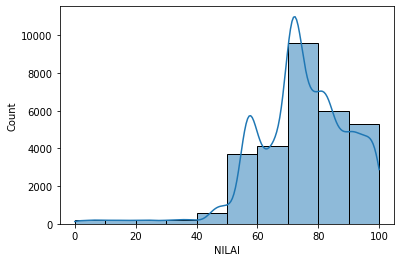

In [216]:
sns.histplot(data=df1, x='NILAI', bins=10, kde=True)

#### Pengecekan Hubungan Linier Setiap Kolom

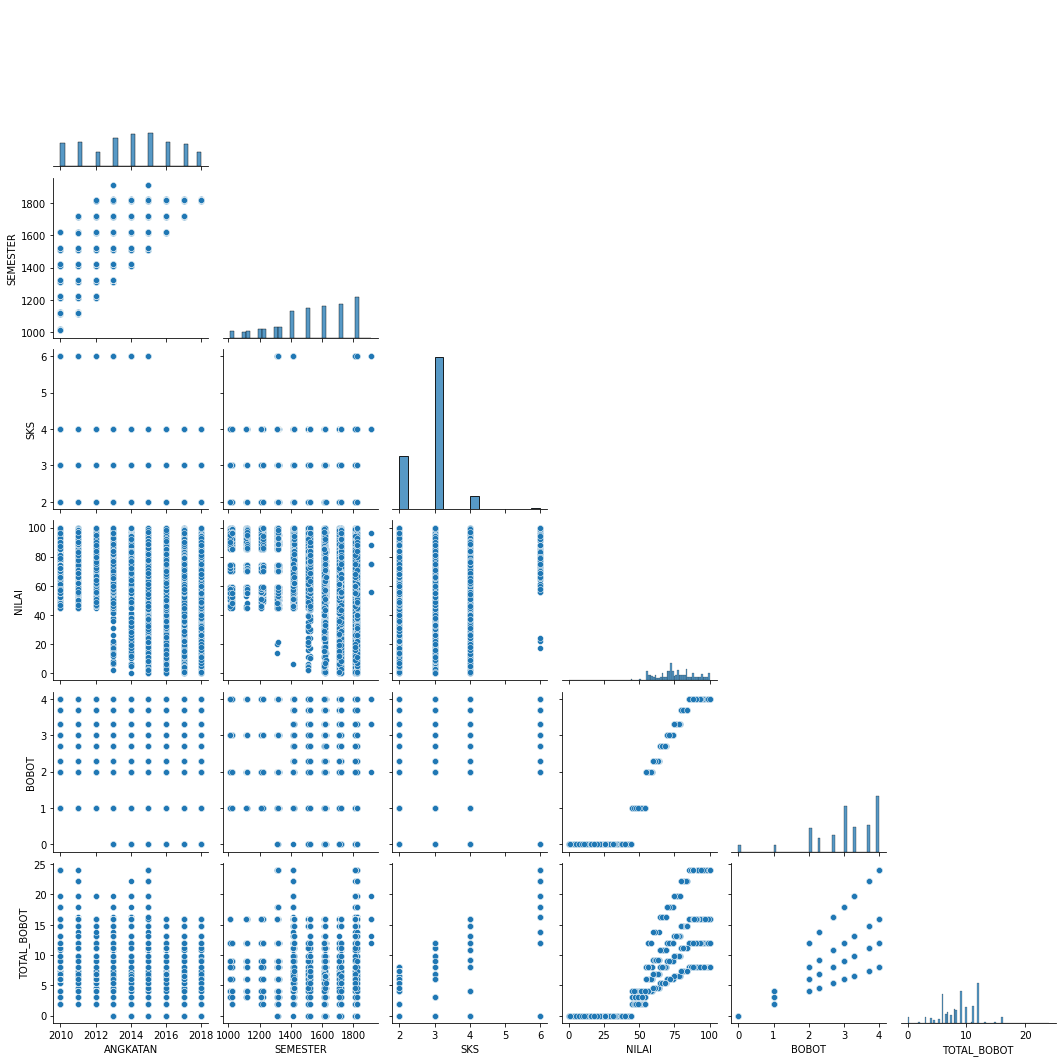

In [217]:
# check hubungan linier
sns.pairplot(data=df1, corner=True)

Berdasarkan scatterplot, terlihat bahwa antar kolom pada data mahasiswa tidak memiliki hubungan linier, kecuali untuk kolom semester dan angkatan (tidak menarik untuk dianalisis)

### Dataframe 2 (Evaluasi Dosen per Mata Kuliah)

#### Boxplot Evaluasi Dosen per Mata Kuliah

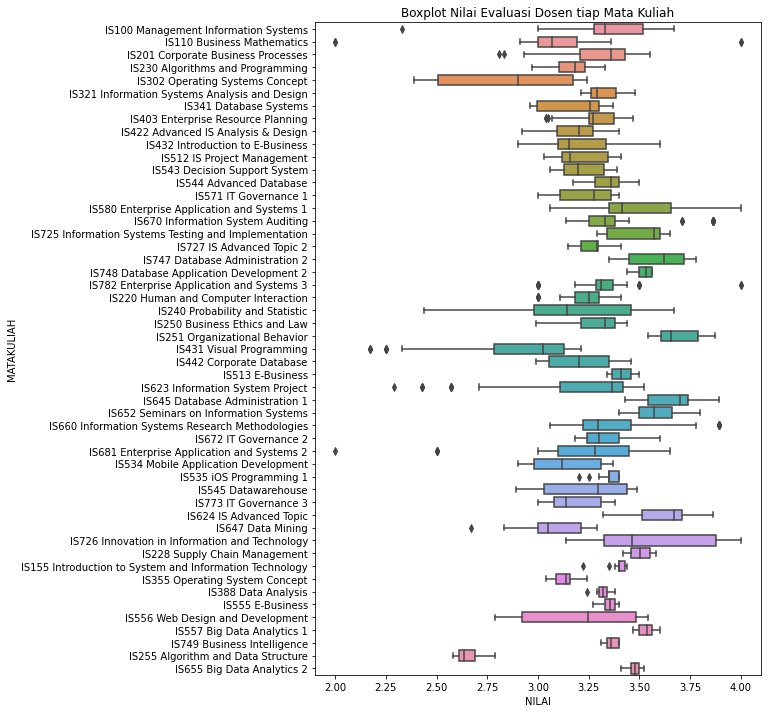

In [218]:
# boxplot evaluasi nilai per matkul

plt.figure(figsize=(8,12))
sns.boxplot(x='NILAI', y='MATAKULIAH', data=df2)
plt.title('Boxplot Nilai Evaluasi Dosen tiap Mata Kuliah')
plt.show()

Berdasarkan plot di atas, dosen mata kuliah Algorithm and Data Structure memiliki penilaian yang cenderung kecil dibandingkan mata kuliah lainnya.

#### Box Plot Evaluasi Dosen per Pertanyaan

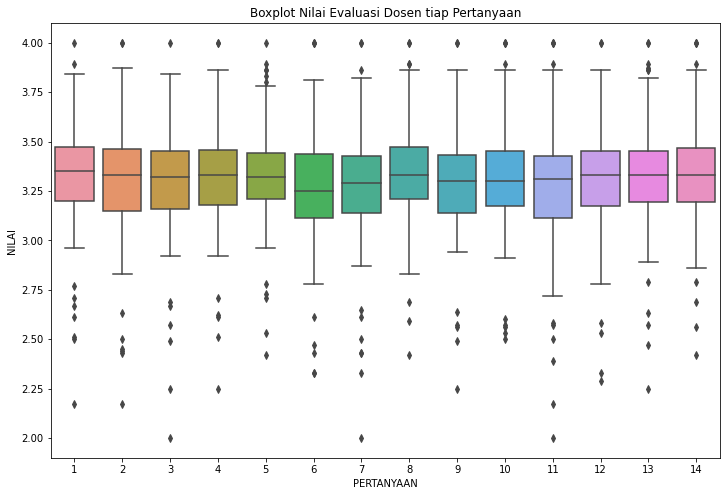

In [219]:
# boxplot evaluasi nilai dosen per pertanyaan

plt.figure(figsize=(12,8))
sns.boxplot(x='PERTANYAAN', y='NILAI', data=df2)
plt.title('Boxplot Nilai Evaluasi Dosen tiap Pertanyaan')
plt.show()

Berdasarkan plot di atas, tiap pertanyaan mengenai evaluasi dosen memiliki rata-rata nilai yang cenderung sama

#### Rata-rata Nilai Dosen per Tahun

In [220]:
# Rata-rata penilaian dosen per tahun

df2_d = df2.groupby('TAHUN')['NILAI'].mean().reset_index()
df2_d

,TAHUN,NILAI
0,2015,3.269231
1,2016,3.267432
2,2017,3.363956
3,2018,3.351299


##### Plot Rata-rata Nilai Dosen per Tahun

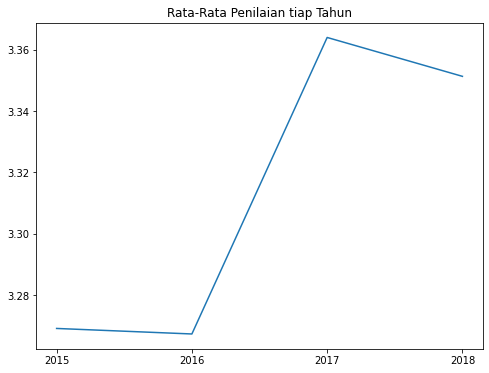

In [221]:
# plot rata-rata nilai evaluasi dosen per tahun

plt.figure(figsize=(8,6))
plt.plot(df2_d['TAHUN'], df2_d['NILAI'])
plt.title('Rata-Rata Penilaian tiap Tahun')
plt.xticks(df2_d['TAHUN'])
plt.show()

Overall naik \
Penilaian dosen meningkat pesat dari 2016 ke 2017 \
Ada penurunan sekitar 0.01 dari 2017 ke 2018

#### Rata-rata Penilaian tiap Pertanyaan

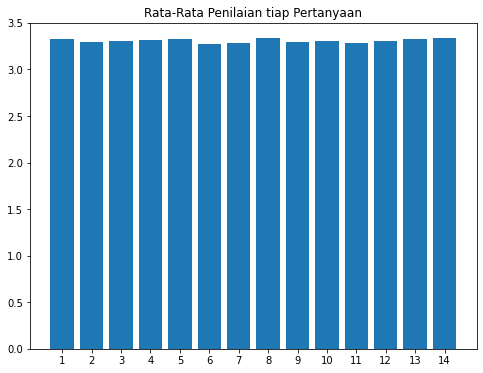

In [222]:
df2_dd = df2.groupby('PERTANYAAN')['NILAI'].mean().reset_index()

plt.figure(figsize=(8,6))
plt.bar(df2_dd['PERTANYAAN'], df2_dd['NILAI'])
plt.title('Rata-Rata Penilaian tiap Pertanyaan')
plt.xticks(df2_dd['PERTANYAAN'])
plt.show()

Berdasarkan bar chart diatas, terlihat bahwa tidak ada pertanyaan dengan penilaian rata-rata yang berbeda secara signifikan

Text(0.5, 1.0, 'Rata-Rata Penilaian Tahunan tiap Pertanyaan')

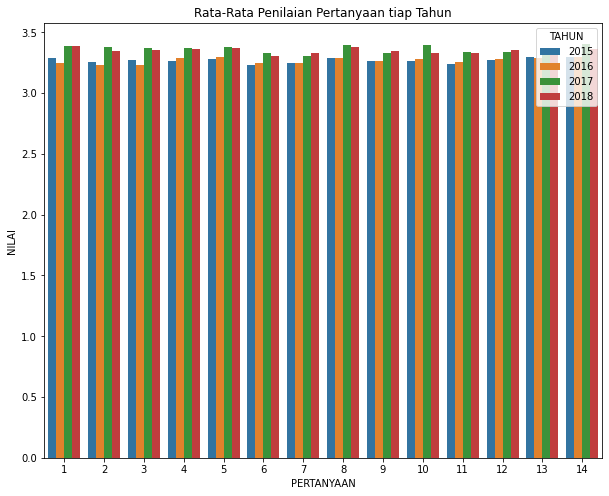

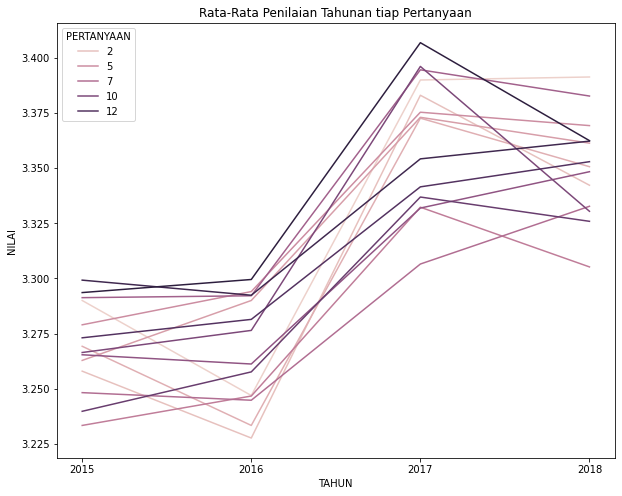

In [223]:
df2_ddd = df2.groupby(['TAHUN', 'PERTANYAAN'])['NILAI'].mean().reset_index()

plt.figure(figsize=(10,8))
sns.barplot(x='PERTANYAAN', y='NILAI', data=df2_ddd, hue='TAHUN')
plt.title('Rata-Rata Penilaian Pertanyaan tiap Tahun')

plt.figure(figsize=(10,8))
sns.lineplot(x='TAHUN', y='NILAI', data=df2_ddd, hue='PERTANYAAN')
plt.xticks([2015, 2016, 2017, 2018])
plt.title('Rata-Rata Penilaian Tahunan tiap Pertanyaan')

Tiap pertanyaan memiliki rataan penilaian yang meningkat pesat dari 2016 ke 2017 \
Berarti secara rata-rata, dosen memiliki kinerja yang lebih baik, terlebih lagi dari 2015 ke 2016 banyak penurunan

### Dataframe 3

#### Statistika Deskriptif

In [224]:
# statistika deskriptif df3
df3.describe()

,ANGKATAN,TOTAL_SKS,TOTAL_BOBOT,WAKTU_KULIAH,IPK,TOTAL_FAILED_GRADE
count,770.000000,770.000000,770.000000,770.000000,770.000000,770.000000
mean,2014.707792,110.763636,337.295714,2.716234,2.943970,2.320779
std,2.598202,41.083773,153.354122,1.437582,0.608181,3.409191
min,2010.000000,40.000000,0.000000,0.500000,0.000000,0.000000
25%,2013.000000,82.000000,193.625000,1.500000,2.673277,0.000000
50%,2015.000000,134.000000,395.850000,3.500000,3.034729,1.000000
75%,2017.000000,145.000000,463.875000,3.500000,3.340000,3.000000
max,2018.000000,148.000000,580.000000,6.500000,4.000000,21.000000


In [225]:
df3["HASIL"].value_counts()

Tidak Lulus          589
Lulus Tepat Waktu    174
Lulus Telat            7
Name: HASIL, dtype: int64

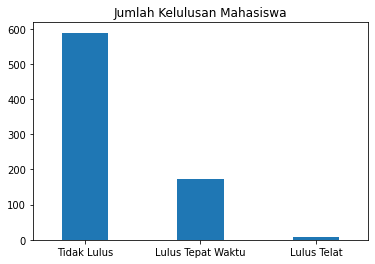

In [226]:
# plot kelulusan mahasiswa

df3["HASIL"].value_counts().plot(kind='bar', width=0.4)
plt.xticks(rotation=0)
plt.title('Jumlah Kelulusan Mahasiswa')
plt.show()

Berdasarkan plot kelulusan mahasiswa, masih banyak mahasiswa yang belum lulus dibandingkan yang dapat lulus. \
Oleh karena itu, data mahasiswa ini tidak seimbang untuk pemodelan.

#### Distribusi total SKS

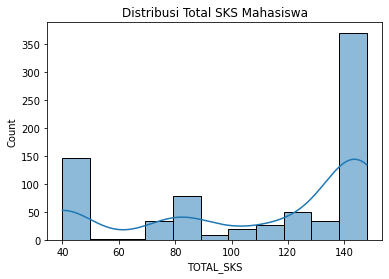

In [227]:
# histogram/distribusi total sks
sns.histplot(data=df3, x='TOTAL_SKS', kde=True)
plt.title('Distribusi Total SKS Mahasiswa')
plt.show()

Histogram menunjukkan bahwa, mayorita mahasiswa mengambil SKS dengan total lebih dari 140 SKS  

#### Distribusi Waktu Kuliah

catatan : waktu kuliah dalam tahun

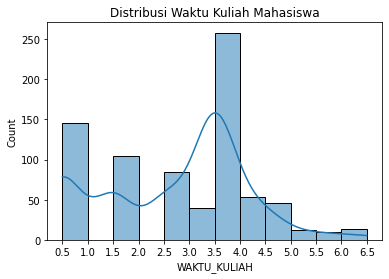

In [228]:
# histogram/distribusi waktu kuliah
bin = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
sns.histplot(data=df3, x='WAKTU_KULIAH', bins=bin, kde=True)
plt.xticks(bin)
plt.title('Distribusi Waktu Kuliah Mahasiswa')
plt.show()

Mahasiswa paling banyak berkuliah selama 3,5 hingga 4 tahun

#### Distribusi IPK

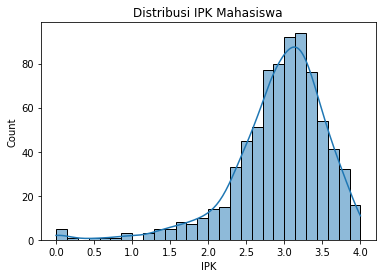

In [229]:
# histogram/distribusi ipk

sns.histplot(data=df3, x='IPK', kde=True)
plt.title('Distribusi IPK Mahasiswa')
plt.show()

In [230]:
print('IPK Skewness:', skew(df3['IPK']))
print('IPK Kurtosis:', kurtosis(df3['IPK']))
print('IPK Avg:', df3['IPK'].mean())

IPK Skewness: -1.5035917059355945
IPK Kurtosis: 4.178268491050808
IPK Avg: 2.9439700926765258


Data berdistribusi menceng ke kiri (negatif), hal ini dapat dilihat dari histogram yang terbentuk

#### Pengecekan Keliniearan Tiap Kolom

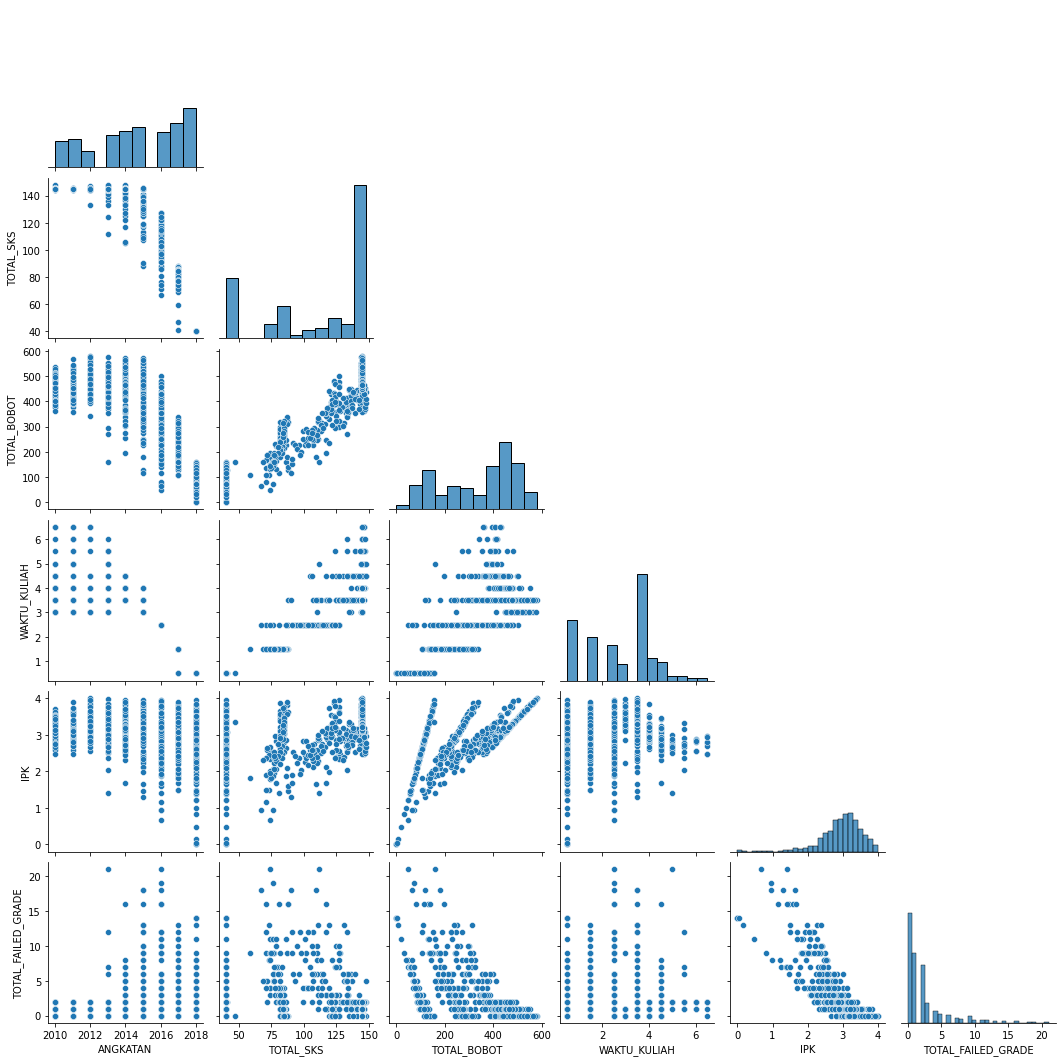

In [231]:
# check hubungan linier df3

sns.pairplot(data=df3, corner=True)

Berdasarkan plot di atas, antar kolom pada dataframe 3 tidak memiliki hubungan linier

### Dataframe 4 dan 5

#### Tren Kelulusan Mahasiswa per Tahun

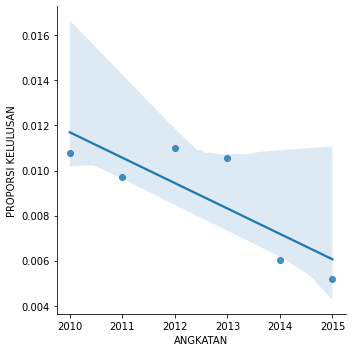

In [232]:
# plot tren kelulusan mahasiswa
sns.lmplot(data=df5, x='ANGKATAN', y='PROPORSI KELULUSAN')

Data menunjukkan adanya tren menurun untuk jumlah mahasiswa yang lulus

#### Pengecekan Kelinearan Kolom Proporsi Kelulusan Mahasiswa dengan Nilai Rata-rata Evaluasi Dosen

Correlation : 0.34080563254288343


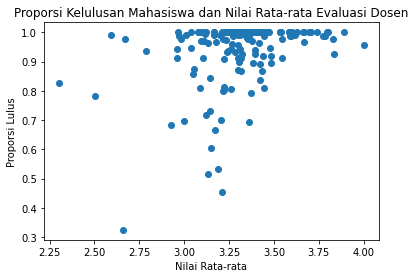

In [233]:
plt.scatter(df4["NILAI_RATA-RATA"], df4["PROPORSI_LULUS"])
plt.title("Proporsi Kelulusan Mahasiswa dan Nilai Rata-rata Evaluasi Dosen")
plt.xlabel("Nilai Rata-rata")
plt.ylabel("Proporsi Lulus")
print("Correlation :", np.corrcoef(df4["NILAI_RATA-RATA"], df4["PROPORSI_LULUS"])[0,1])

Rata-rata penilaian dosen tidak menunjukkan hubungan linear terhadap banyaknya mahasiswa yang lulus pada kelas yang bersangkutan

#### Pengecekan Kelinearan Kolom Proporsi Kelulusan Mahasiswa dengan Nilai Evaluasi Dosen Tiap Pertanyaan 

Correlation Pertanyaan-1 : 0.2533343274253512
Correlation Pertanyaan-2 : 0.3344677394326155
Correlation Pertanyaan-3 : 0.2945092950903338
Correlation Pertanyaan-4 : 0.3304842404466105
Correlation Pertanyaan-5 : 0.3110261658447846
Correlation Pertanyaan-6 : 0.282125506420109
Correlation Pertanyaan-7 : 0.36803240438423374
Correlation Pertanyaan-8 : 0.33471910755179607
Correlation Pertanyaan-9 : 0.337698832536608
Correlation Pertanyaan-10 : 0.2954303228586778
Correlation Pertanyaan-11 : 0.3921414708813768
Correlation Pertanyaan-12 : 0.3427288390232669
Correlation Pertanyaan-13 : 0.3789473595132128
Correlation Pertanyaan-14 : 0.2695238344623883


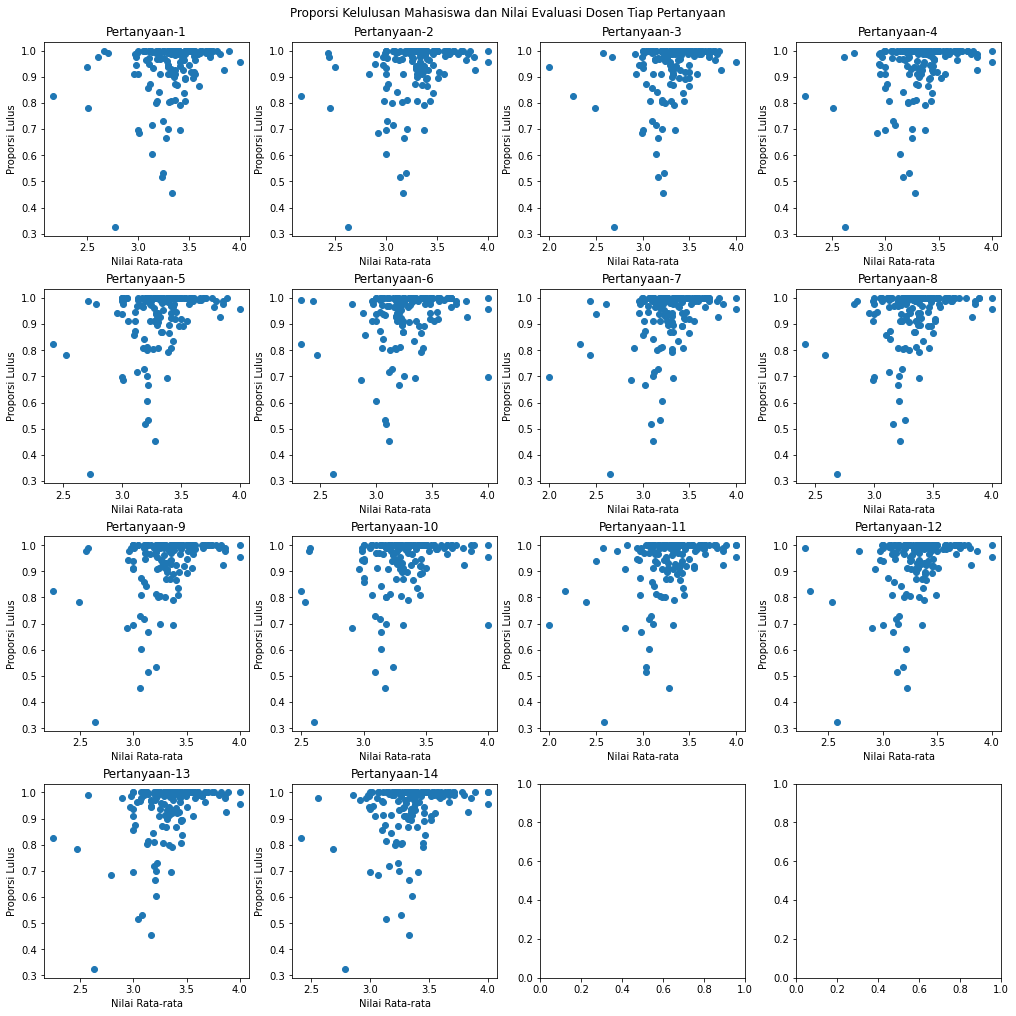

In [234]:
fig, ax = plt.subplots(4, 4, figsize=(14,14), constrained_layout=True)

x = 0
y = 0

fig.suptitle("Proporsi Kelulusan Mahasiswa dan Nilai Evaluasi Dosen Tiap Pertanyaan")
for i in range(0,14): 
    y = i % 4
    ax[x,y].set_title("Pertanyaan-" + str(i+1))
    ax[x,y].scatter(df4[i+1],df4["PROPORSI_LULUS"])
    ax[x,y].set_xlabel("Nilai Rata-rata")
    ax[x,y].set_ylabel("Proporsi Lulus")
    print("Correlation Pertanyaan-" + str(i+1) + " : " + str(np.corrcoef(df4[i+1],df4["PROPORSI_LULUS"])[0,1]))
    if(y == 3):
        x += 1
        y = 0

nilai evaluasi dosen untuk tiap pertanyaan juga tidak menunjukkan adanya hubungan linear terhadap proporsi kelulusan mahasiswa. \
sehingga, dapat disimpulkan bahwa, Kualitas dosen tidak menunjukkan adanya linearitas terhadap performa mahasiswa

## Evaluasi Model

#### Pemisahan data untuk Angkatan 2010-2015 dan 2016-2018

In [436]:
df6 = pd.DataFrame(df3.loc[df3["ANGKATAN"] <= 2015])
df6

,NIM,ANGKATAN,TOTAL_SKS,FAILED_GRADE,TOTAL_BOBOT,WAKTU_KULIAH,IPK,TOTAL_FAILED_GRADE,HASIL
0,00000008429,2015,145,D,474.5,3.5,3.272414,1.0,Tidak Lulus
1,00000008455,2015,136,DD,416.2,3.5,3.060294,2.0,Tidak Lulus
2,00000008481,2015,127,DDDEEED,313.6,3.5,2.469291,7.0,Tidak Lulus
3,00000008631,2015,145,,519.3,3.0,3.581379,0.0,Lulus Tepat Waktu
4,00000008684,2015,145,,512.1,3.0,3.531724,0.0,Lulus Tepat Waktu
...,...,...,...,...,...,...,...,...,...
765,14110310095,2014,145,DD,469.9,4.0,3.240690,2.0,Tidak Lulus
766,14110310098,2014,145,D,464.1,4.0,3.200690,1.0,Tidak Lulus
767,14110310101,2014,138,,438.4,4.5,3.176812,0.0,Tidak Lulus
768,14110310102,2014,133,EEE,362.2,4.5,2.723308,3.0,Tidak Lulus


### Sampling Data

In [439]:
np.random.seed(42)

# features and target variables
X = df6[['TOTAL_FAILED_GRADE', 'IPK']]
y = df6['HASIL']

<AxesSubplot:>

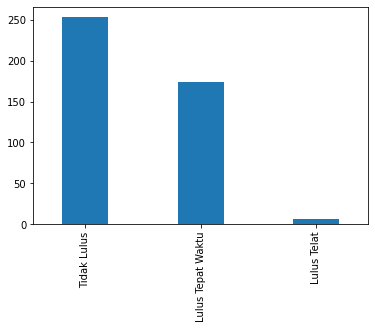

In [440]:
y.value_counts().plot(kind="bar", width=0.4)

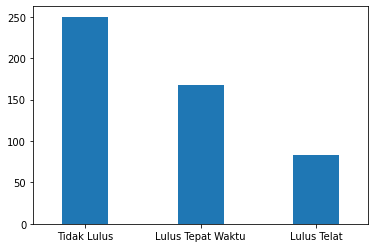

In [441]:
# sampling the dataset 

ros = RandomOverSampler(sampling_strategy='all')
rus = RandomUnderSampler(sampling_strategy={'Tidak Lulus' : 250, 'Lulus Telat' : 83, 'Lulus Tepat Waktu' : 167})

X_ros, y_ros = ros.fit_resample(X, y) 
X_rus, y_rus = rus.fit_resample(X_ros, y_ros) 

y_rus.value_counts().plot(kind="bar", width=0.4)
plt.xticks(rotation=0)
plt.show()

### Modelling

In [442]:
# split dataset
X_train, X_val, y_train, y_val = train_test_split(X_rus, y_rus, test_size=0.25, shuffle=True, random_state=42)

In [486]:
# spot-check algorithm
models = [('LR', LogisticRegression()),
         ('CART', DecisionTreeClassifier()),
         ('RF', RandomForestClassifier()),
         ('SVC', SVC()),
         ('KNN', KNeighborsClassifier())]

models_name = []
results = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    models_name.append(name)
    results.append(cv_score)
    print(f'{name} \t | cv_score_mean: {cv_score.mean()} \t | cv_score_std: {cv_score.std()}')

LR 	 | cv_score_mean: 0.9226666666666669 	 | cv_score_std: 0.015549205052920814
CART 	 | cv_score_mean: 0.9866666666666667 	 | cv_score_std: 0.008432740427115663
RF 	 | cv_score_mean: 0.9866666666666667 	 | cv_score_std: 0.008432740427115663
SVC 	 | cv_score_mean: 0.8586666666666666 	 | cv_score_std: 0.018086213288334037
KNN 	 | cv_score_mean: 0.9653333333333333 	 | cv_score_std: 0.013597385369580781


<AxesSubplot:>

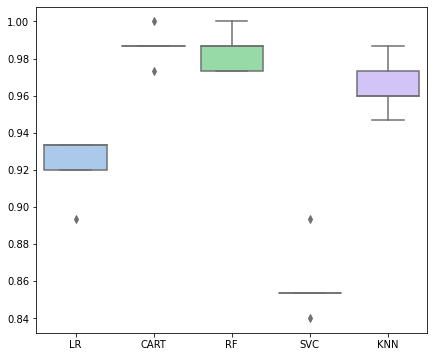

In [444]:
# boxplot comparing models

results_df = pd.DataFrame(np.asarray(results).T, columns=models_name)

plt.figure(figsize=(7,6))
sns.boxplot(data=results_df, palette='pastel')

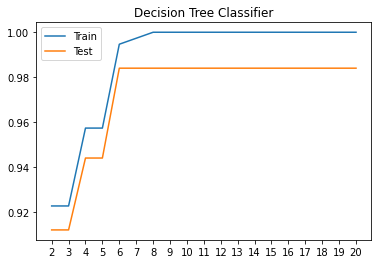

In [445]:
train_acc = []
test_acc = []

depth = np.arange(2, 21, 1)

for i in depth:
    cart = DecisionTreeClassifier(max_depth=i)
    cart.fit(X_train, y_train)
    pred = cart.predict(X_train)
    accuracy = accuracy_score(y_train, pred)
    train_acc.append(accuracy)

    pred = cart.predict(X_val)
    accuracy = accuracy_score(y_val, pred)
    test_acc.append(accuracy)

plt.plot(depth, train_acc)
plt.plot(depth, test_acc)
plt.legend(["Train", "Test"])
plt.xticks(depth)
plt.title("Decision Tree Classifier")
plt.show()

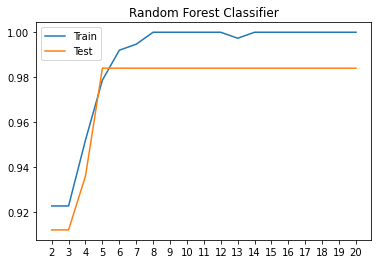

In [446]:
train_acc = []
test_acc = []

depth = np.arange(2, 21, 1)

for i in depth:
    cart = RandomForestClassifier(max_depth=i)
    cart.fit(X_train, y_train)
    pred = cart.predict(X_train)
    accuracy = accuracy_score(y_train, pred)
    train_acc.append(accuracy)

    pred = cart.predict(X_val)
    accuracy = accuracy_score(y_val, pred)
    test_acc.append(accuracy)

plt.plot(depth, train_acc)
plt.plot(depth, test_acc)
plt.legend(["Train", "Test"])
plt.title("Random Forest Classifier")

plt.xticks(depth)
plt.show()

In [1]:
# metrics for model evaluation

def evaluate_model(y_true, y_pred, model):
    print(f'{model} Evaluation')
    print('-'*70)
    print('accuracy score:', accuracy_score(y_true, y_pred))
    print('\nclassification report:\n', classification_report(y_true, y_pred))
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6,6))
    ax = sns.heatmap(conf_matrix, square=True, annot=True, fmt='.3g', annot_kws={'fontsize': 13},cmap='Blues',
                     xticklabels=['Lulus Telat', 'Lulus Tepat Waktu', 'Tidak Lulus'], yticklabels=['Lulus Telat', 'Lulus Tepat Waktu', 'Tidak Lulus'])
    fig.suptitle('Confusion Matrix')
    ax.set_xlabel('Prediction Labels')
    ax.set_ylabel('True Labels')
    return ax

### Decision Tree

In [449]:
# check maximum depth of the tree
acc_score = []

def checkMaxDepth(X, y):
    depth = np.arange(2, 21, 1)

    for i in depth:
        cart = DecisionTreeClassifier(max_depth=i)
        cart.fit(X_train, y_train)
        pred = cart.predict(X_val)
        accuracy = accuracy_score(y_val, pred)
        acc_score.append(accuracy)
        print(f'max_depth: {i} \t | accuracy score: {accuracy}')

checkMaxDepth(X=X_train, y=y_train)
print("Depth with highest accuracy score :", acc_score.index(max(acc_score))+2)

max_depth: 2 	 | accuracy score: 0.912
max_depth: 3 	 | accuracy score: 0.912
max_depth: 4 	 | accuracy score: 0.944
max_depth: 5 	 | accuracy score: 0.944
max_depth: 6 	 | accuracy score: 0.984
max_depth: 7 	 | accuracy score: 0.984
max_depth: 8 	 | accuracy score: 0.984
max_depth: 9 	 | accuracy score: 0.984
max_depth: 10 	 | accuracy score: 0.984
max_depth: 11 	 | accuracy score: 0.984
max_depth: 12 	 | accuracy score: 0.984
max_depth: 13 	 | accuracy score: 0.984
max_depth: 14 	 | accuracy score: 0.984
max_depth: 15 	 | accuracy score: 0.984
max_depth: 16 	 | accuracy score: 0.984
max_depth: 17 	 | accuracy score: 0.984
max_depth: 18 	 | accuracy score: 0.984
max_depth: 19 	 | accuracy score: 0.984
max_depth: 20 	 | accuracy score: 0.984
Depth with highest accuracy score : 6


In [450]:
# train the model
cart = DecisionTreeClassifier(max_depth=6)
# cart = KNeighborsClassifier(n_neighbors=3)
cart.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6)

In [451]:
# prediction on validation set

y_preds = cart.predict(X_val)

# evaluating accuracy

print("accuracy score:", accuracy_score(y_val, y_preds))

accuracy score: 0.984


DecisionTreeClassifier(max_depth=6) Evaluation
----------------------------------------------------------------------
accuracy score: 0.984

classification report:
                    precision    recall  f1-score   support

      Lulus Telat       0.97      1.00      0.98        28
Lulus Tepat Waktu       0.97      0.97      0.97        33
      Tidak Lulus       1.00      0.98      0.99        64

         accuracy                           0.98       125
        macro avg       0.98      0.98      0.98       125
     weighted avg       0.98      0.98      0.98       125



<AxesSubplot:xlabel='Prediction Labels', ylabel='True Labels'>

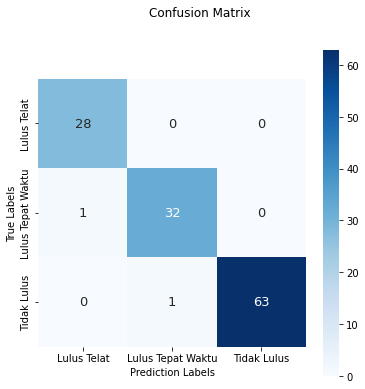

In [452]:
evaluate_model(y_val, y_preds, model=cart)

In [453]:
df7 = pd.DataFrame(df3.loc[df3["ANGKATAN"] > 2015])
df7 = df7.drop(columns='HASIL')
df7

,NIM,ANGKATAN,TOTAL_SKS,FAILED_GRADE,TOTAL_BOBOT,WAKTU_KULIAH,IPK,TOTAL_FAILED_GRADE
96,00000012779,2016,127,,478.1,2.5,3.764567,0.0
97,00000012880,2016,123,,412.7,2.5,3.355285,0.0
98,00000012905,2016,123,,476.5,2.5,3.873984,0.0
99,00000012906,2016,127,,460.4,2.5,3.625197,0.0
100,00000012910,2016,127,,500.3,2.5,3.939370,0.0
...,...,...,...,...,...,...,...,...
427,00000033607,2018,40,ED,99.2,0.5,2.480000,2.0
428,00000033657,2018,40,D,127.8,0.5,3.195000,1.0
429,00000033708,2018,40,D,114.3,0.5,2.857500,1.0
430,00000033849,2018,40,EEEEEEDEE,33.0,0.5,0.825000,9.0


In [456]:
X = df7[['TOTAL_FAILED_GRADE', 'IPK']]

<AxesSubplot:>

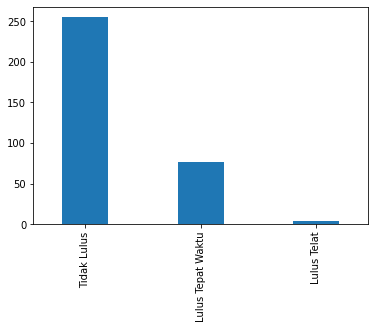

In [457]:
df7['HASIL'] = cart.predict(X)
# evaluating accuracy

# df7['HASIL'].loc[df7["ANGKATAN"] == 2018].value_counts().plot(kind="bar", width=0.4)
df7['HASIL'].value_counts().plot(kind="bar", width=0.4)

In [461]:
df7.loc[df7["HASIL"] == "Tidak Lulus"]

,NIM,ANGKATAN,TOTAL_SKS,FAILED_GRADE,TOTAL_BOBOT,WAKTU_KULIAH,IPK,TOTAL_FAILED_GRADE,HASIL
102,00000013019,2016,113,DEDDDF,281.6,2.5,2.492035,6.0,Tidak Lulus
103,00000013049,2016,122,DDD,363.0,2.5,2.975410,3.0,Tidak Lulus
104,00000013058,2016,124,DD,393.6,2.5,3.174194,2.0,Tidak Lulus
106,00000013119,2016,121,DE,382.0,2.5,3.157025,2.0,Tidak Lulus
108,00000013291,2016,111,EDD,317.8,2.5,2.863063,3.0,Tidak Lulus
...,...,...,...,...,...,...,...,...,...
426,00000033603,2018,40,E,98.1,0.5,2.452500,1.0,Tidak Lulus
427,00000033607,2018,40,ED,99.2,0.5,2.480000,2.0,Tidak Lulus
428,00000033657,2018,40,D,127.8,0.5,3.195000,1.0,Tidak Lulus
429,00000033708,2018,40,D,114.3,0.5,2.857500,1.0,Tidak Lulus
